In [ ]:
# !pip install langchain_google_genai

  Using cached langchain_google_genai-2.1.0-py3-none-any.whl.metadata (3.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.


In [1]:
!pip install --q -U langchain_google_genai langchain_core langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 862.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.9/415.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.


In [2]:
from google.colab import userdata
import os

GEMINI_API_KEY = userdata.get('gemini_api_key')
os.environ["GEMINI_API_KEY"] = GEMINI_API_KEY

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a:int,b:int)->int:
  """ Multiply a and b

  Args:
    a: first int
    b: second int

   """

  return a*b

def divide(a:int,b:int)->float:
  """ Divide a and b

  Args:
    a: first int
    b: second int

   """

  return a/b

def add(a:int,b:int)->int:
  """ add a and b

  Args:
    a: first int
    b: second int

   """

  return a+b

def subtract(a:int,b:int)->int:
  """ subtract a and b

  Args:
    a: first int
    b: second int

   """

  return a-b

tools = [multiply,divide,add,subtract]
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key =GEMINI_API_KEY )
llm_with_tools = llm.bind_tools(tools)

In [4]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content= "You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state:MessagesState)-> MessagesState:
  return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

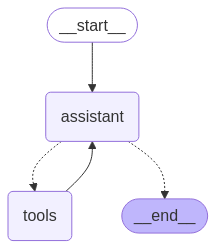

In [5]:
from langgraph.graph import START,StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langgraph.graph.state import CompiledStateGraph

builder:StateGraph = StateGraph(MessagesState)

builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools","assistant")
graph:CompiledStateGraph = builder.compile()
graph

In [6]:
messages = [ HumanMessage(content="What is 2 + 3 and 2 multiply 6")]
messages = graph.invoke({"messages":messages})

for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

What is 2 + 3 and 2 multiply 6
================================== Ai Message ==================================
Tool Calls:
  add (906bc7d9-ff20-4110-b194-9c7fa1715442)
 Call ID: 906bc7d9-ff20-4110-b194-9c7fa1715442
  Args:
    a: 2.0
    b: 3.0
  multiply (e03db62f-48fc-4942-8cd1-ed9979a2163b)
 Call ID: e03db62f-48fc-4942-8cd1-ed9979a2163b
  Args:
    a: 2.0
    b: 6.0
================================= Tool Message =================================
Name: add

5
================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================

2 + 3 = 5 and 2 * 6 = 12.


In [ ]:
messages

{'messages': [HumanMessage(content='What is 2 + 3 and 2 multiply 6', additional_kwargs={}, response_metadata={}, id='91695deb-1795-4101-9786-4b7e28597154'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 6.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-511c77ae-fac5-49f8-893c-7a41bb907144-0', tool_calls=[{'name': 'add', 'args': {'a': 2.0, 'b': 3.0}, 'id': '71d199b3-e404-4614-bd04-a496720105c7', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 2.0, 'b': 6.0}, 'id': 'c84f59ee-84b8-4d7c-ae39-48fc517c6d86', 'type': 'tool_call'}], usage_metadata={'input_tokens': 80, 'output_tokens': 6, 'total_tokens': 86, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='5', name='add', id='29c3b1d2-1b7e-4396-9e77-55d030ec6281', tool_call_id='71d199b3-e404-4614-bd04-a496720105c7'),
  ToolMessage(content='12', name='multiply'

In [8]:
from langgraph.checkpoint.memory import MemorySaver

memory:MemorySaver = MemorySaver()

graph_memory: CompiledStateGraph = builder.compile(checkpointer=memory)

In [10]:
config = {"configurable":{"thread_id":"1"}}

messages = [ HumanMessage(content="What is 2 + 3 ")]
messages = graph_memory.invoke({"messages":messages},config)

for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

What is 2 + 3 
================================== Ai Message ==================================
Tool Calls:
  add (a946cc03-e22a-4b95-93b0-bb5cf4646f0f)
 Call ID: a946cc03-e22a-4b95-93b0-bb5cf4646f0f
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================

2 + 3 = 5


In [11]:
messages = [ HumanMessage(content="Now multiply by 2")]
messages = graph_memory.invoke({"messages":messages},config)

for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

What is 2 + 3 
================================== Ai Message ==================================
Tool Calls:
  add (a946cc03-e22a-4b95-93b0-bb5cf4646f0f)
 Call ID: a946cc03-e22a-4b95-93b0-bb5cf4646f0f
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================

2 + 3 = 5
================================ Human Message =================================

Now multiply by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (2258f0d9-6300-4914-9ba3-3a744dd737b8)
 Call ID: 2258f0d9-6300-4914-9ba3-3a744dd737b8
  Args:
    a: 5.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================

